This notebook is attempting to replicate `torch.unfold` in Python in order to be able to get the original patch coordinates for each of the unfolded patches.

In [3]:
%matplotlib inline

from PIL import Image
import numpy as np
import torch
from torchvision.transforms import v2

Image.MAX_IMAGE_PIXELS = 933120000
image = Image.open('images/cars.jpg')
# image = Image.open('images/large-sat-image-color.jpg')
image_arr = np.array(image)
image_tensor = torch.tensor(image_arr)
print("array: ", image_arr.shape, image_arr.dtype, image_arr.size * image_arr.itemsize)
print("tensor: ", image_tensor.shape, image_tensor.dtype)

size = 768
overlap = 0.2
stride = int(size * (1 - overlap))
device = (
  "cuda" if torch.cuda.is_available()
  else "mps" if torch.backends.mps.is_built() else "cpu"
)
print('Using', device)

array:  (4256, 2832, 3) uint8 36158976
tensor:  torch.Size([4256, 2832, 3]) torch.uint8
Using cuda


## In-Memory Tiling, 768x768, 20% overlap
Findings for 36158976 byte image:
* Creates 35 tiles in 17.4ms
* Loads 35 tiles into GPU in 90ms, consuming 64800 KiB of GPU memory
* With slices, only consumes 35311 KiB of GPU memory

Findings for 754384896 byte image:
* Creates 675 tiles in 37ms
* Loads 675 tiles into GPU memory in 300ms, consuming 1160 MiB of GPU memory
* With slices, consumes only 737280 MiB of GPU memory

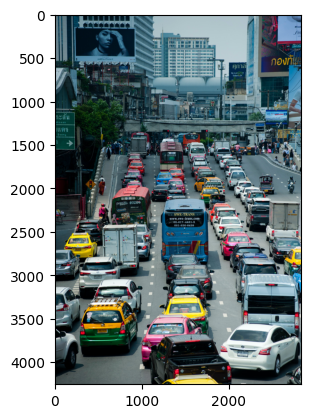

In [4]:
from matplotlib import pyplot as plt

plt.imshow(image_arr)
plt.show()

In [5]:
%%time
# Create tiles using the t1 tiling code. This uses CPU to create views onto the
# original array.

import cv2
import math
from matplotlib import pyplot as plt
import tiling

tiles = tiling.tile_image(image_arr, size, size, overlap)

CPU times: user 9.55 ms, sys: 7.65 ms, total: 17.2 ms
Wall time: 17 ms


In [6]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [7]:
%%time
# time building the tiles and moving them into GPU
import cv2
import math
from matplotlib import pyplot as plt
import tiling
import torch

tiles = tiling.tile_image(image_arr, size, size, overlap)
tensors = []
for tile in tiles:
    tensors.append(torch.tensor(tile.tile).to("cuda"))

CPU times: user 131 ms, sys: 103 ms, total: 234 ms
Wall time: 78.2 ms


In [8]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from large pool |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from small pool |      0 KiB |      0 KiB |      0 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from large pool |  60480 KiB |  60480 KiB |  60480 KiB |

In [9]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from large pool |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from small pool |      0 KiB |      0 KiB |      0 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  60480 KiB |  60480 KiB |  60480 KiB |      0 B   |
|       from large pool |  60480 KiB |  60480 KiB |  60480 KiB |

In [10]:
%%time
# time building the tiles and moving them into GPU
import cv2
import math
from matplotlib import pyplot as plt
import tiling
import torch

tiles = tiling.tile_image(image_arr, size, size, overlap)
image_tensor = torch.tensor(image_arr).to("cuda")
tensors = []
for tile in tiles:
    tensors.append(image_tensor[tile.x:size, tile.y:size, :])

CPU times: user 73.9 ms, sys: 11.7 ms, total: 85.5 ms
Wall time: 11.4 ms


In [11]:
print(len(tiles))

35


In [12]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from large pool |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from small pool |      0 KiB |      0 KiB |      0 KiB |      0 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from large pool |  35311 KiB |  95791 KiB |  95791 KiB |

## GPU Tiling
Findings for 36158976 byte image:
* Creates 24 tiles in 72ms in GPU memory, consuming 76783 KiB of GPU memory.

Findings for 754384896 byte image:
* Create 624 tiles in 130ms in GPU memory, consuming 1774 MiB of GPU memory.

In [13]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from large pool |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from small pool |      0 KiB |      0 KiB |      0 KiB |      0 KiB |
|---------------------------------------------------------------------------|
| Active memory         |  35311 KiB |  95791 KiB |  95791 KiB |  60480 KiB |
|       from large pool |  35311 KiB |  95791 KiB |  95791 KiB |

In [14]:
%%time

import tqdm
import torch
from torchvision.transforms import v2

batch_size = 5

def convert_nhwc_to_nchw(batch):
    return batch.permute(0, 3, 1, 2)

with torch.no_grad():
    cuda_image = image_tensor.to(device).detach()
    chw = cuda_image.permute(2, 0, 1)
    unfolded = chw.unfold(1, size, stride).unfold(2, size, stride)
    hwc = unfolded.permute(1, 2, 3, 4, 0)
    batches = hwc.reshape(hwc.shape[0] * hwc.shape[1], hwc.shape[2], hwc.shape[3], hwc.shape[4])
    batches = convert_nhwc_to_nchw(batches)

CPU times: user 3.4 ms, sys: 3.67 ms, total: 7.06 ms
Wall time: 6.71 ms


In [15]:
print("batches:", batches.shape)

batches: torch.Size([24, 3, 768, 768])


In [5]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1774 MiB |   1774 MiB |   1774 MiB |      0 B   |
|       from large pool |   1774 MiB |   1774 MiB |   1774 MiB |      0 B   |
|       from small pool |      0 MiB |      0 MiB |      0 MiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |   1774 MiB |   1774 MiB |   1774 MiB |      0 B   |
|       from large pool |   1774 MiB |   1774 MiB |   1774 MiB |

## Comparing Tiles

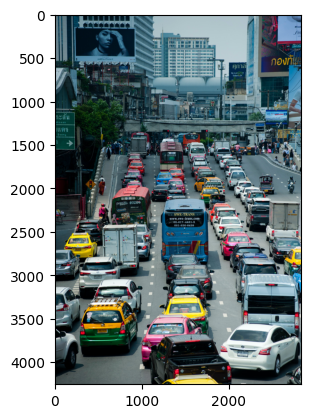

In [27]:
from matplotlib import pyplot as plt

plt.imshow(image_arr)
plt.show()

total tiles: 35


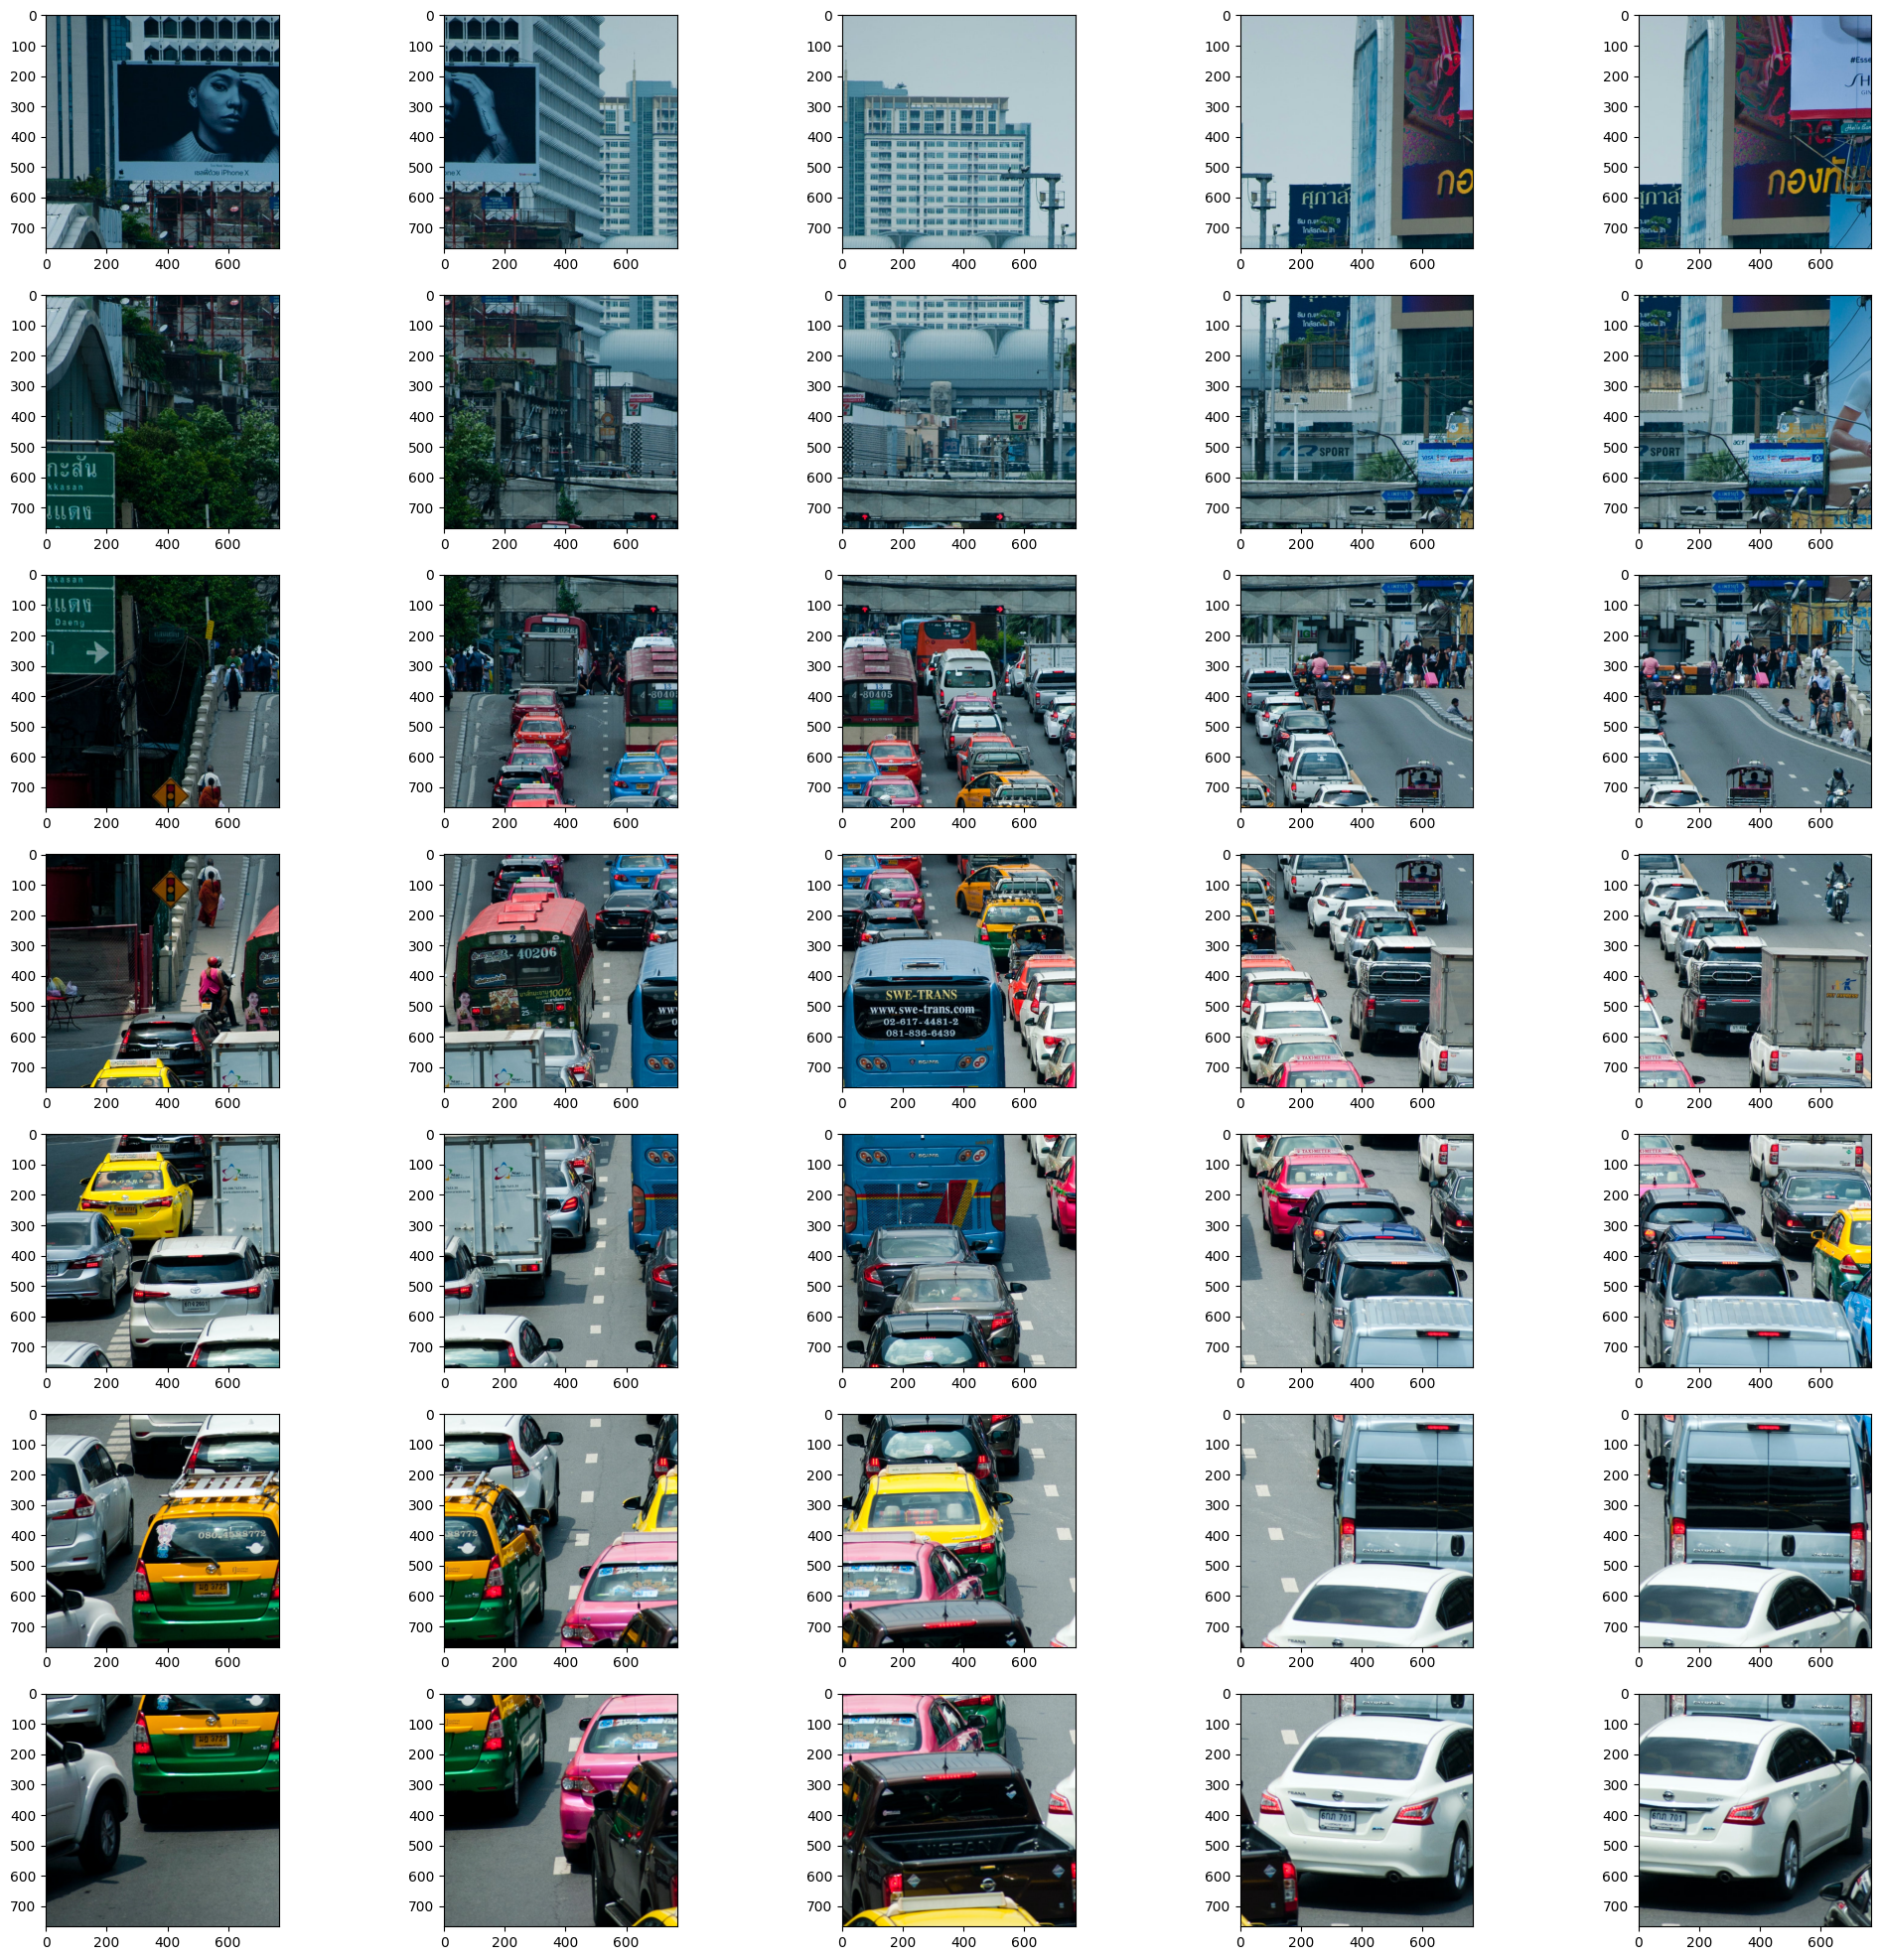

In [155]:
import math
from matplotlib import pyplot as plt
import tiling

tiles = tiling.tile_image(image_arr, size, size, overlap)
height, width = tiles[0].tile.shape[:2]
for tile in tiles:
    h, w = tile.tile.shape[:2]
    if h != height or w != width:
        raise "Not all tiles have the same size!"    

total_tiles = len(tiles)
print("total tiles:", total_tiles)
rows = math.ceil(total_tiles / 5)
f,ax = plt.subplots(rows, 5, figsize=(25, 25))
for idx, tile in enumerate(tiles):
    row = int(idx / 5)
    ax[row, idx % 5].imshow(tile.tile)
plt.show()

before padding: (4256, 2832, 3)
after padding: (4452, 3224, 3)


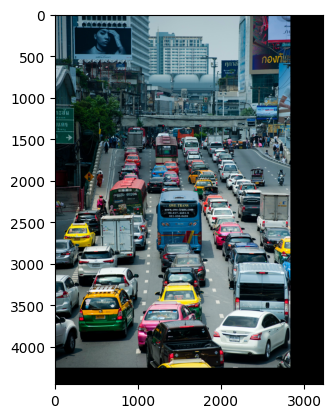

In [148]:
import math
import tqdm
import torch
from torchvision.transforms import v2

batch_size = 5

def convert_nhwc_to_nchw(batch):
    return batch.permute(0, 3, 1, 2)

def pad_square(image: np.ndarray) -> np.ndarray:
    """Pads an image with black pixels to make it square.

    This method assumes that image is a height x width x channels array. The
    padding is added to the right or the bottom of the image so that it can be
    removed without affecting annotations in the coordinate space.
    """
    height, width = image.shape[:2]
    if height == width:
        return image
    
    if height > width:
        pad_value = np.zeros((
            height, height - width, image.shape[2]), dtype=image.dtype)
        return np.concatenate((image, pad_value), axis=1)
    else:
        pad_value = np.zeros((
            width - height, width, image.shape[2]), dtype=image.dtype)
        return np.concatenate((image, pad_value), axis=0)

def pad_strided(image: np.ndarray, size: int, stride: int) -> np.ndarray:
    """Pads an image with black pixels to make it square.

    This method assumes that image is a height x width x channels array. The
    padding is added to the right or the bottom of the image so that it can be
    removed without affecting annotations in the coordinate space.
    """
    height, width = image.shape[:2]
    to_return = image
    needs_height_padding = (height - size) % stride
    needs_width_padding = (width - size) % stride
    if needs_height_padding:
        height_entries = int((height - size) / stride) + 1
        height_padding = (stride * height_entries + size) - height
        padding = np.zeros((
            height_padding, width, image.shape[2]), dtype=image.dtype)
        to_return = np.concatenate((to_return, padding), axis=0)
        height = to_return.shape[0]
    if needs_width_padding:
        width_entries = int((width - size) / stride) + 1
        width_padding = (stride * width_entries + size) - width
        padding = np.zeros((
            height, width_padding, image.shape[2]), dtype=image.dtype)
        to_return = np.concatenate((to_return, padding), axis=1)
    return to_return

with torch.no_grad():
    print('before padding:', image_arr.shape)
    padded = pad_strided(image_arr, size, stride)
    print('after padding:', padded.shape)
    plt.imshow(padded)
    plt.show()
    image_tensor = torch.tensor(padded)
    cuda_image = image_tensor.to(device).detach()
    # Pad the images to begin with.
    
    chw = cuda_image.permute(2, 0, 1)
    unfolded = chw.unfold(1, size, stride).unfold(2, size, stride)
    hwc = unfolded.permute(1, 2, 3, 4, 0)
    batches = hwc.reshape(hwc.shape[0] * hwc.shape[1], hwc.shape[2], hwc.shape[3], hwc.shape[4])
    batches = convert_nhwc_to_nchw(batches)

torch.Size([35, 3, 768, 768])


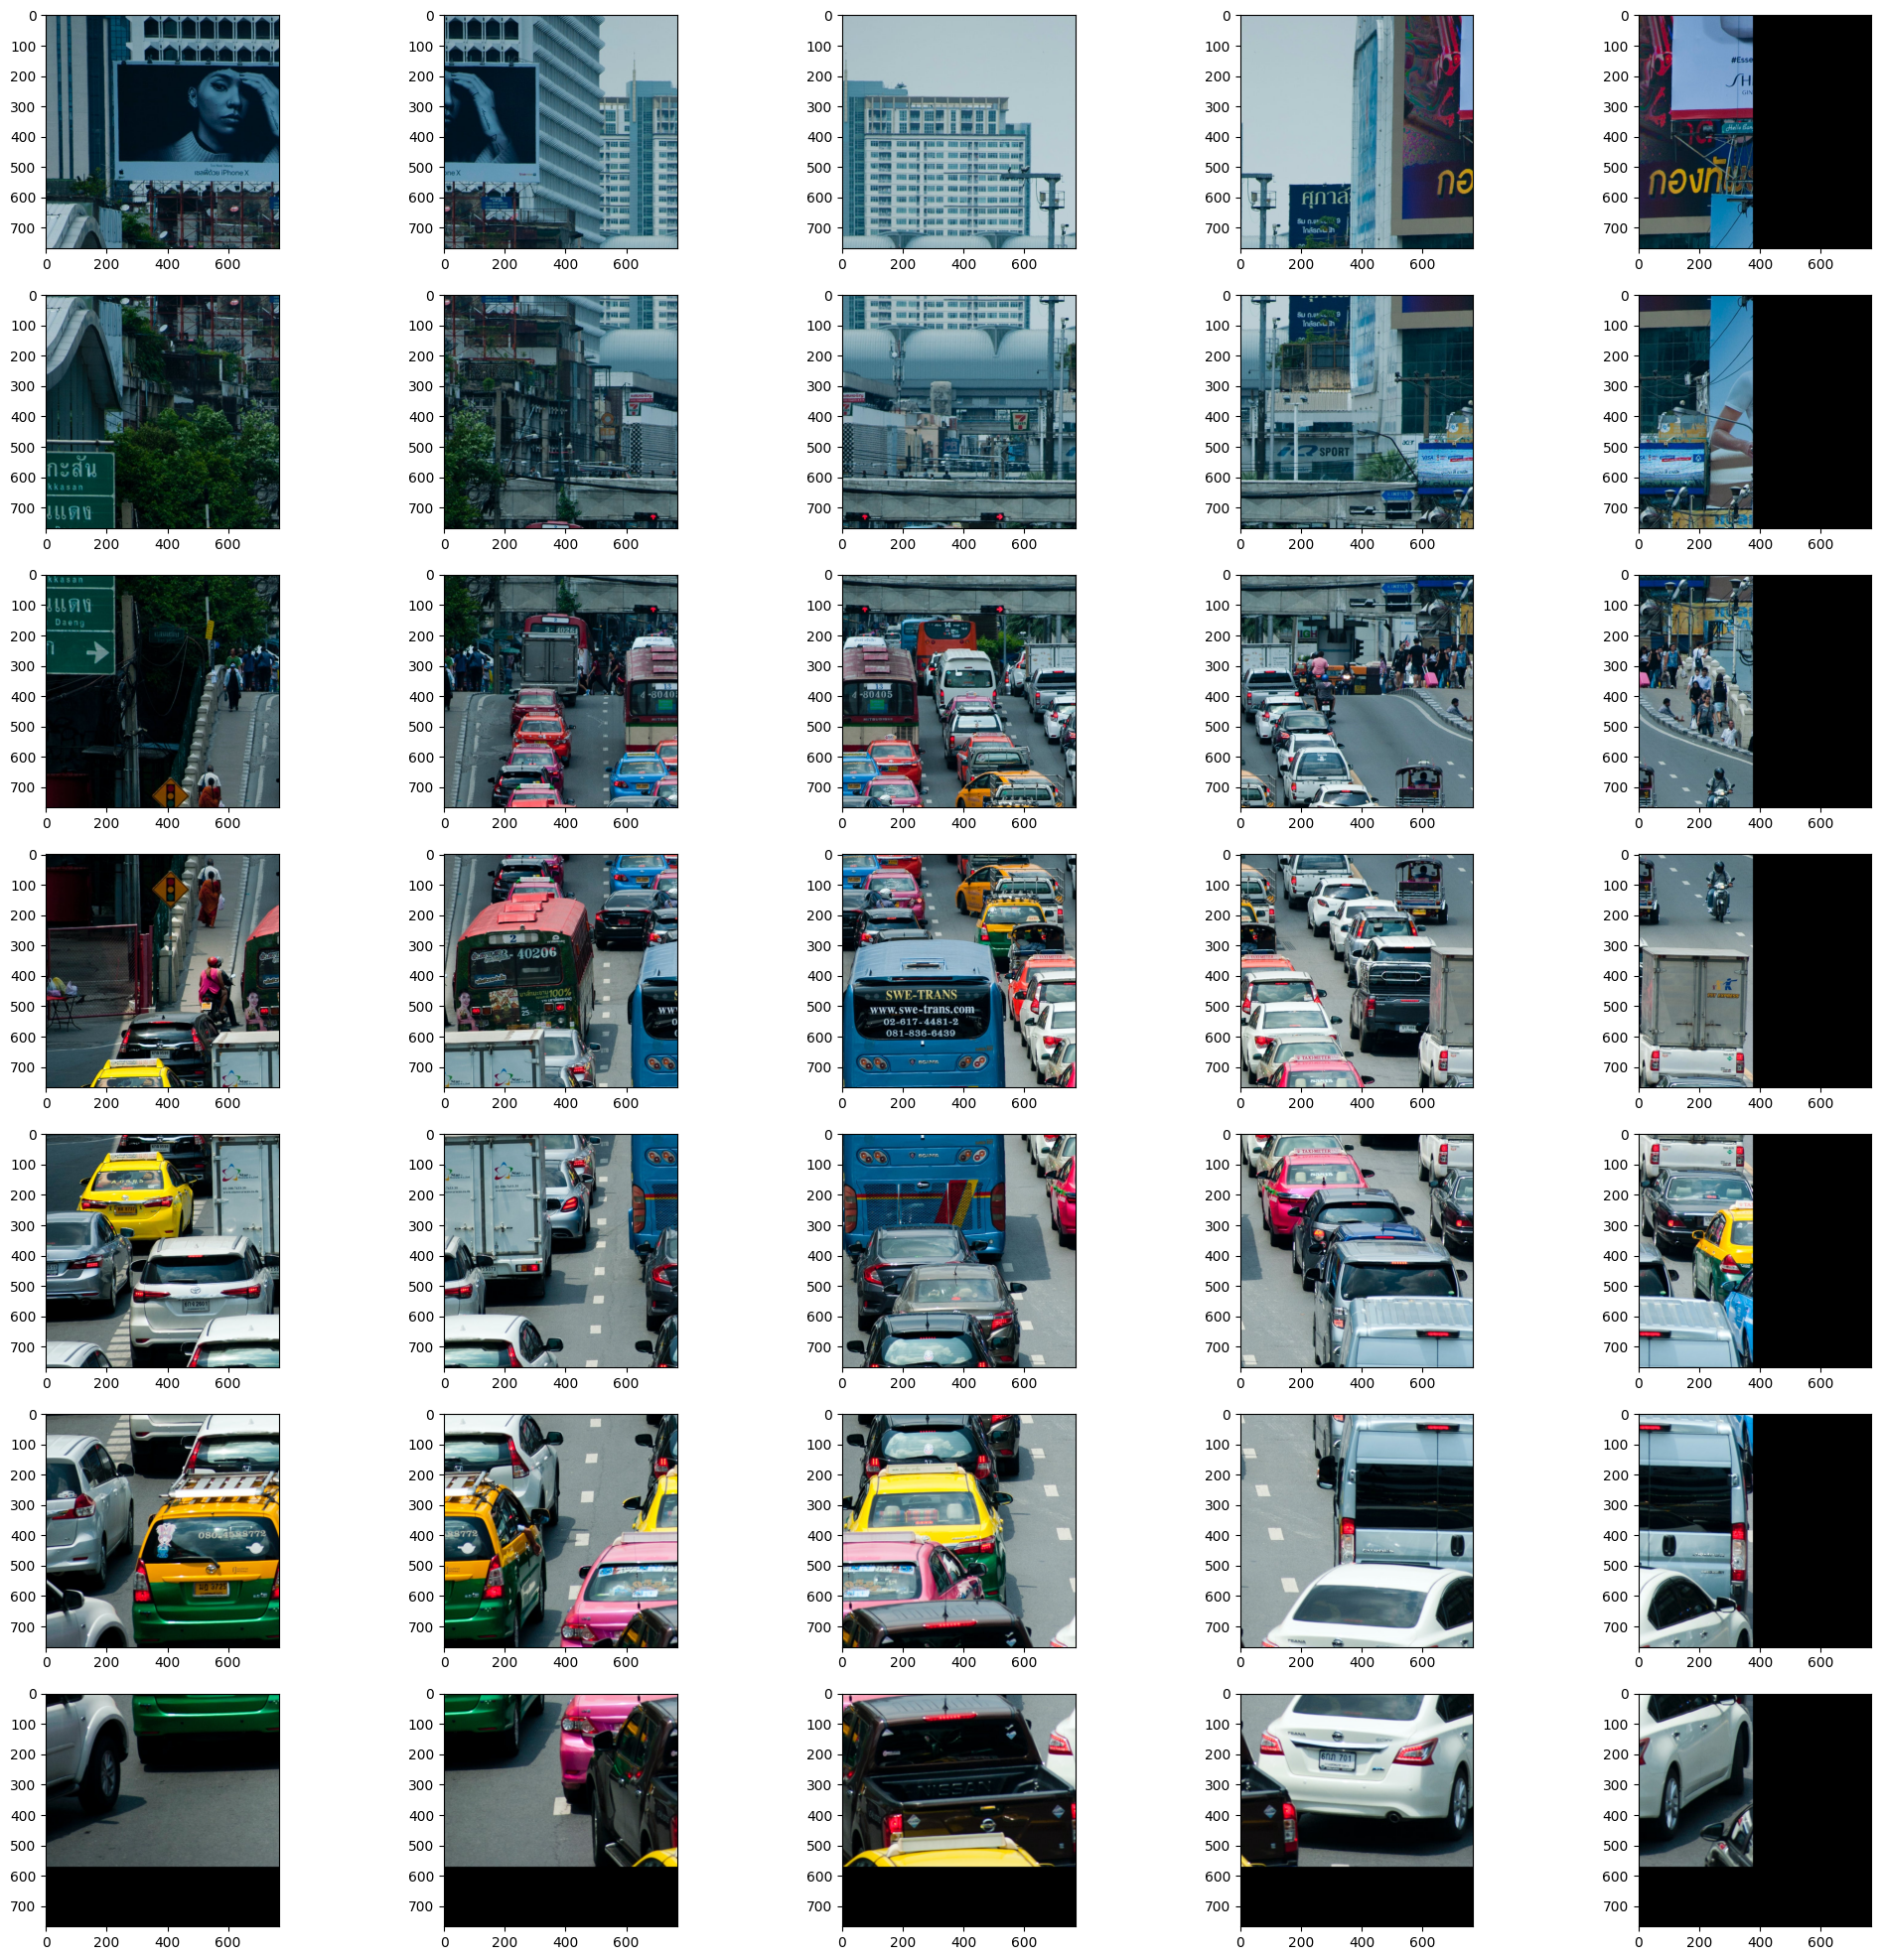

In [152]:
to_show = batches.to("cpu")
print(to_show.shape)
rows = math.ceil(to_show.shape[0] / 5)
f,ax = plt.subplots(rows, 5, figsize=(25, 25))
for i in range(batches.shape[0]):
    row = int(i / 5)
    ax[row, i % 5].imshow(to_show[i].permute(1, 2, 0))
plt.show()

## Unfold seems to be missing the last frame of a row. See if this can be repeated:
It appears that when stride does not divide equally into a dimension, unfold drops some last set of data.

In [34]:
import torch

tensor = torch.rand(3, 12, 12)
unfolded = tensor.unfold(1, 4, 2).unfold(2, 4, 2)
unfolded.shape
hwc = unfolded.permute(1, 2, 3, 4, 0)
hwc.shape
# [0-4,2-6,4-8,6-10,8-12]

torch.Size([5, 5, 4, 4, 3])

In [36]:
import torch

tensor = torch.rand(3, 13, 13)
unfolded = tensor.unfold(1, 4, 2).unfold(2, 4, 2)
unfolded.shape
hwc = unfolded.permute(1, 2, 3, 4, 0)
hwc.shape
# [0-4,2-6,4-8,6-10,8-12]

torch.Size([5, 5, 4, 4, 3])